In [8]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [9]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

data_train = OwnDataset(train=True, transform=tf)
data_test = OwnDataset(train=False, transform=tf)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



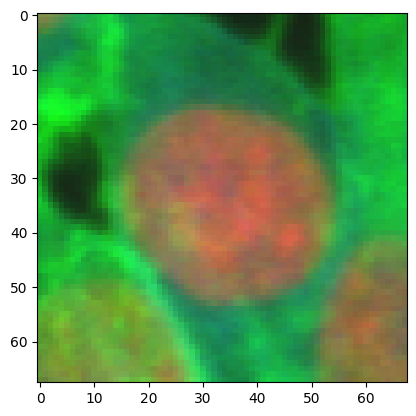

In [10]:
# get a sample image from the dataset
sample = data_train[612][0]

# show the image
show_img(sample.view(3,68,68))


In [11]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


# VAE

In [12]:
from models import VAE_CELL_CNN
from loss_functions import loss_function

model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=2)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
    (10): ReLU()
  )
  (mu): Linear(in_features=512, out_features=2, bias=True)
  (sigma): Linear(in_features=512, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7):

In [13]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat, mu, sigma = output
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])


## Training

In [14]:
num_epochs = 10

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        x_hat, mu, sigma = model(x)
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/10, loss: 25961.313117825255, mse: 25770.207399952167, kld: 191.1057166955909
Epoch 2/10, loss: 13202.79489198023, mse: 12951.222835618622, kld: 251.57206519769161
Epoch 3/10, loss: 11963.68741529815, mse: 11662.668599031409, kld: 301.0188122184909
Epoch 4/10, loss: 11577.116618253747, mse: 11277.568709392937, kld: 299.54792559876734
Epoch 5/10, loss: 11290.82090416733, mse: 10982.642221878987, kld: 308.1786729073038
Epoch 6/10, loss: 11209.44241270727, mse: 10897.970573580995, kld: 311.4718353115782
Epoch 7/10, loss: 11136.87237050582, mse: 10825.641499422034, kld: 311.23087380856884
Epoch 8/10, loss: 11088.326133260922, mse: 10776.241442621971, kld: 312.08467222719776
Epoch 9/10, loss: 11119.362589933435, mse: 10803.23233468192, kld: 316.1302324022566
Epoch 10/10, loss: 11261.673090720664, mse: 10935.731455277424, kld: 325.94160589879874


## Plots

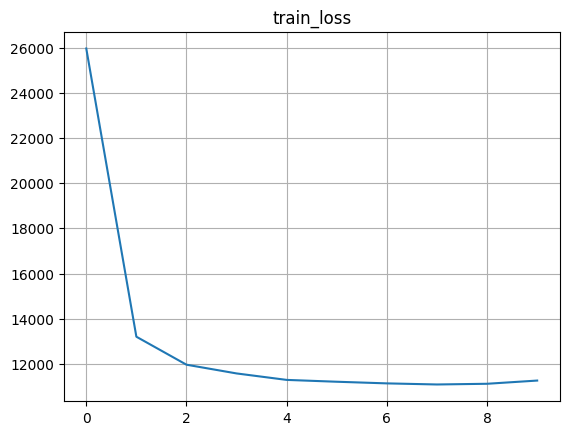

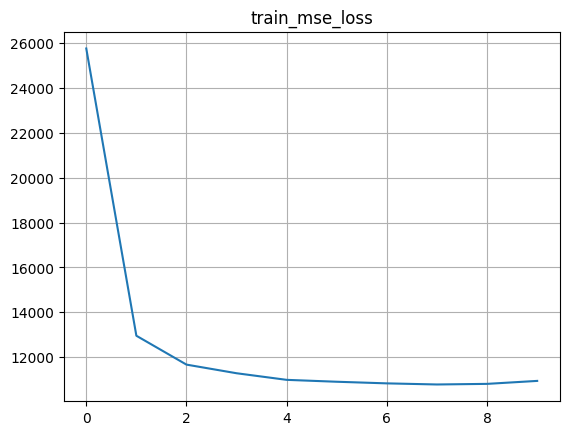

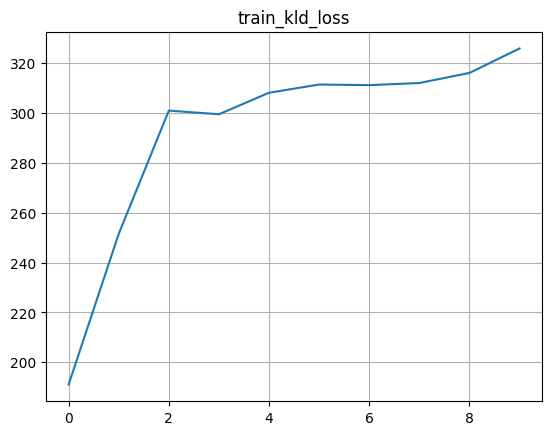

In [15]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


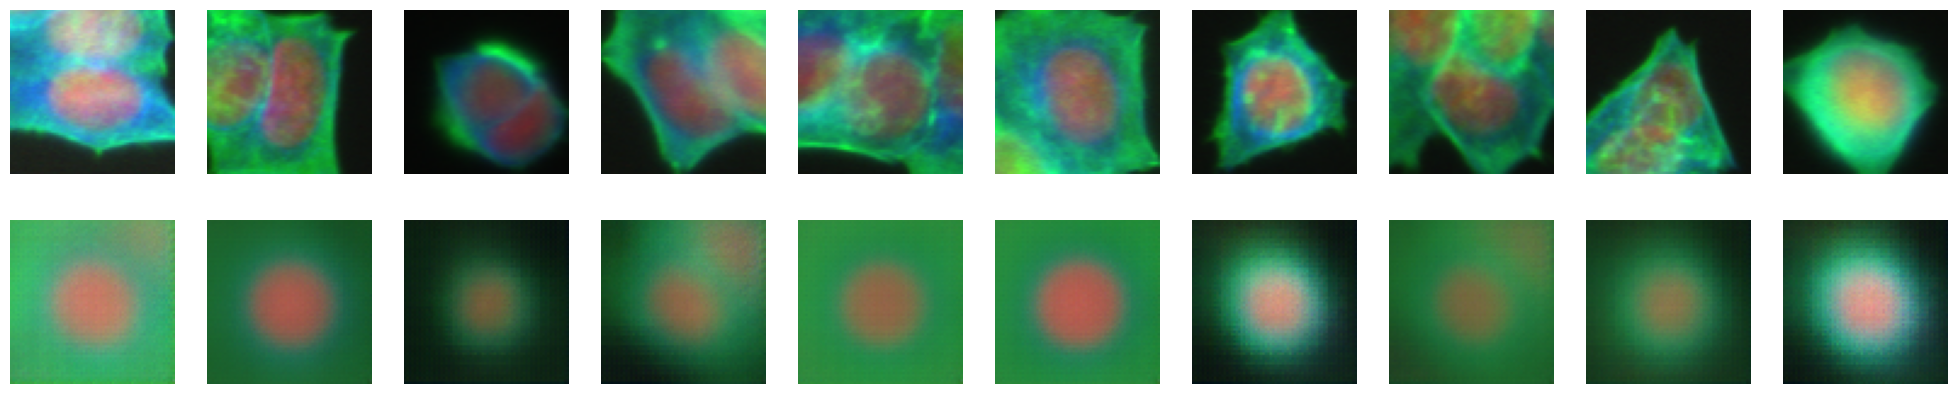

In [16]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


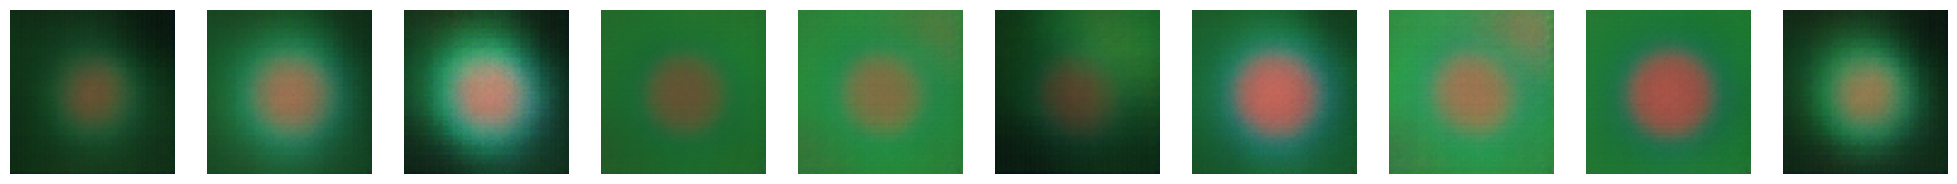

In [17]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [18]:
from inference import Inference

inference = Inference(model, test_loader)

In [19]:
samples = inference.samples